In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bigfile import BigFile
import glob,os,struct
from scipy.interpolate import interp1d
from colossus.cosmology import cosmology
import seaborn as sns

sns.set()
sns.set_palette("Set2")
sns.set_style('ticks',{'ytick.direction':'in','xtick.direction':'in'})

cmap = plt.get_cmap("Set2")
sns.set_context("paper", font_scale=1.7,rc={"axes.linewidth": 1.3,"lines.linewidth": 2.5,"patch.linewidth": 2.2})
from matplotlib import rcParams as rc
import matplotlib as mpl

In [5]:
def load_astrid_cosmo():
    pig = BigFile('/hildafs/datasets/Asterix/PIG_files/PIG_214')
    battr = pig["Header"].attrs
    Lbox = battr['BoxSize']
    hh = battr['HubbleParam']
    om0 = battr['Omega0']
    omb = battr['OmegaBaryon']
    oml = battr['OmegaLambda']
    Nfof = battr['NumFOFGroupsTotal']
    sigma8 = 0.82

    # set-up cosmology
    params = {'flat': True, 'H0': 100*hh, 'Om0': om0, 'Ob0': omb, 'sigma8': sigma8, 'ns': 0.96}
    cosmo = cosmology.setCosmology('myCosmo', params)
    MassTable = battr["MassTable"]
    
    return Lbox, MassTable, cosmo

snaps = np.loadtxt('/hildafs/datasets/Asterix/PIG2/Snapshots.txt')
snap2z = {s[0]:1./s[1]-1 for s in snaps}


# some constants and unit conversions
msun_mks = 1.989e30
pc_mks = 3.086e16
grav_mks = 6.67e-11
km_mks = 1e3
yr_mks = 3.154e+7
c_mks = 3e8

Mpc_to_m = 3.086e+22
m_to_Mpc = 1./Mpc_to_m
s_to_year = 3.17098e-8
c_Mpc_yr = c_mks*m_to_Mpc/s_to_year
fac = 121.14740013761634  # GADGET unit Protonmass / Bolztman const
GAMMA = 5 / 3.
Xh=0.76
hh = h = 0.6774

Lbox, MassTable, cosmo = load_astrid_cosmo()
# conversion between time and redshift
z_arr = np.linspace(0,20,1000)
time = cosmo.age(z_arr) # Gyr
def z_to_t(x):
    return interp1d(z_arr, time,fill_value='extrapolate')(x)
def t_to_z(x):
    return interp1d(time, z_arr,fill_value='extrapolate')(x) 

In [6]:
c_mks = 3e8
msun_mks = 2e30
s_to_year = 3.17098e-8
year_to_s = 1./s_to_year
lsun_ergs = 3.9e33
mdot_msun_yr = 1e10/980/1e6
def calc_lx(mdot):
    """
    input: mdot in Msun/yr
    output: Lx in ergs
    """
    lbol = 0.1*mdot*msun_mks/year_to_s*c_mks**2
    lbol_lsun = lbol/3.9e26
    k = 10.83*(lbol_lsun/1e10)**0.28 \
        + 6.08*(lbol_lsun/1e10)**(-0.02)
    return lbol/k*1e7

def calc_lbol(mdot):
    """
    input: mdot in Msun/yr
    output: Lx in ergs
    """
    lbol = 0.1*mdot*msun_mks/year_to_s*c_mks**2
    lbol_ergs = lbol*1e7
    return lbol_ergs

def edd_ratio(mass,lum):
    return lum/(1.26e38*mass)


### sanity checks

In [7]:
# still need z<1.3 no gal info
merger_root = "/hildafs/datasets/Asterix/BH-mergers"
merger_files = glob.glob(merger_root + "/bh-merger-extended*.npy")
merger_files.sort()

mergers = []
for file in merger_files:
    mergers.append(np.load(file))
mergers = np.concatenate(mergers)

print("merger data fields:", mergers.dtype.names)
print("merger shape:", mergers.shape)

swbh = np.minimum(mergers["ID1"], mergers["ID2"])

uid, uidx = np.unique(swbh, return_index=True)
mergers = mergers[uidx]

print("unique mergers:", len(mergers))

merger data fields: ('z', 'ID1', 'ID2', 'm1', 'm2', 'mdot1', 'mdot2', 'pos1', 'pos2', 'v1', 'v2')
merger shape: (3150770,)
unique mergers: 2959410


In [8]:
root = "/hildafs/home/nianyic/scratch1/Astrid_data/lisa_mbhcat"

data1 = np.load(root + "/lisa_mcat_v2.0_z1.3.npy")
zmin = min(data1["z"])
print("number of mergers in v2.0:", len(data1))
print("v1.0 dtype:", data1.dtype)


data2 = np.load(root + "/post_merger_below1.3.npy")


print("number of mergers in z<1.3:", len(data2))
print("v2.0 dtype:", data2.dtype)

number of mergers in v2.0: 1887462
v1.0 dtype: [('z', '<f8'), ('ID1', '<i8'), ('ID2', '<i8'), ('m1', '<f8'), ('m2', '<f8'), ('mdot1', '<f8'), ('mdot2', '<f8'), ('mstot', '<f8'), ('zsnap', '<f8'), ('dr', '<f8')]
number of mergers in z<1.3: 1193437
v2.0 dtype: [('zmerge', '<f8'), ('id1', '<i8'), ('id2', '<i8'), ('dr', '<f8'), ('m1', '<f8'), ('m2', '<f8'), ('m4tot', '<f8'), ('mhtot', '<f8'), ('sigma', '<f8'), ('rho', '<f8'), ('gamma', '<f8'), ('zsnap', '<f8'), ('snap_num', '<i4')]


#### combine data: get mdot, dr from extended-merger data and get mstot, zsnap from gal cat

In [9]:
minid1 = np.minimum(mergers["ID1"], mergers["ID2"])
dict1 = {minid1[i]: d for i, d in enumerate(mergers)}

print(len(mergers), len(dict1.keys()))

minid2 = np.minimum(data2["id1"], data2["id2"])



2959410 2959410


In [10]:
data2.dtype

dtype([('zmerge', '<f8'), ('id1', '<i8'), ('id2', '<i8'), ('dr', '<f8'), ('m1', '<f8'), ('m2', '<f8'), ('m4tot', '<f8'), ('mhtot', '<f8'), ('sigma', '<f8'), ('rho', '<f8'), ('gamma', '<f8'), ('zsnap', '<f8'), ('snap_num', '<i4')])

In [11]:
dtype_new = np.dtype([('z', '<f8'), ('ID1', '<i8'), ('ID2', '<i8'), ('m1', '<f8'), ('m2', '<f8'), ('mdot1', '<f8'), ('mdot2', '<f8'), ('mstot', '<f8'), ('zsnap', '<f8'), ('dr', '<f8')])
data_new = []

for i, d2 in enumerate(data2):
    if minid2[i] not in dict1:
        continue
    mdot1 = dict1[minid2[i]]["mdot1"]
    mdot2 = dict1[minid2[i]]["mdot2"]
    
    data_new.append((d2["zmerge"], d2["id1"], d2["id2"], d2["m1"], \
        d2["m2"], mdot1, mdot2, d2["m4tot"], d2["zsnap"], d2["dr"]))
    
    


In [12]:
print(len(data_new))
data_new = np.array(data_new, dtype=dtype_new)

1193437


In [13]:
all_data = np.concatenate([data1, data_new])
print("total number of mergers:", len(all_data))
# take unique event

swbh = np.minimum(all_data["ID1"], all_data["ID2"])

uid, uidx = np.unique(swbh, return_index=True)
all_data = all_data[uidx]

print("unique mergers:", len(all_data))


total number of mergers: 3080899
unique mergers: 2942148


In [14]:
vsim = 250**3
zbin = np.linspace(1.316,6,40)
dz = zbin[1:] - zbin[:-1]
zc = 0.5*(zbin[1:]+zbin[:-1])
rc = np.array([cosmo.comovingDistance(0.,zz) for zz in zc])

n0,e0 = np.histogram(all_data["z"],bins=zbin)
rate0 = n0/dz/vsim*4*np.pi*rc**2*c_Mpc_yr

Text(0.5, 1.0, 'Merger Rate')

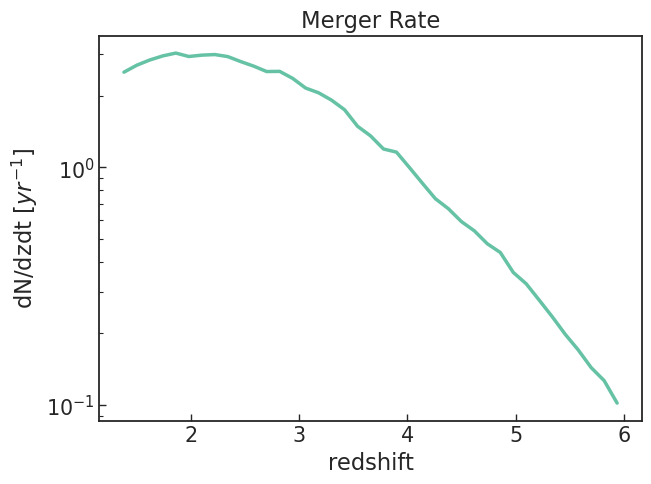

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.plot(zc, rate0)
ax.set(xlabel="redshift", ylabel=r"dN/dzdt [$yr^{-1}$]", yscale="log")
# plt.yscale('log')
ax.set_title("Merger Rate")


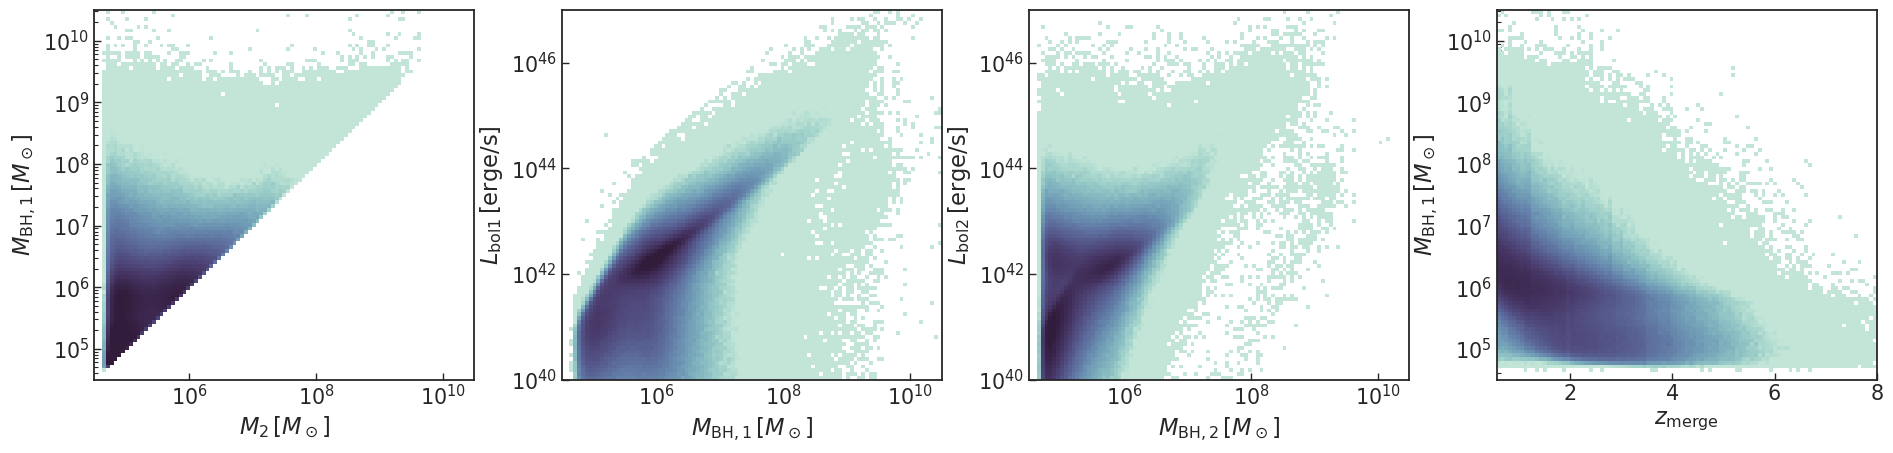

In [16]:
mergers = all_data

cc3 = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

fig, ax = plt.subplots(1,4,figsize=(23,4.8))
plt.subplots_adjust(wspace=0.23)
ax = ax.flatten()


ymin, ymax = 4.5, 10.5
xmin, xmax = 4.5, 10.5

xbins = np.logspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)
ax[0].hist2d(mergers['m2'], mergers['m1'], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[0].set(xscale='log', yscale='log', xlabel=r'$M_{2}\,[M_\odot]$', ylabel=r'$M_{\rm BH, 1}\,[M_\odot]$')


xmin, xmax = 4.5, 10.5
ymin, ymax = 40,47

xbins = np.logspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)

lbol1 = calc_lbol(mergers["mdot1"])
lbol2 = calc_lbol(mergers["mdot2"])

ax[1].hist2d(mergers['m1'], lbol1, bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[1].set(xscale='log', yscale='log', xlabel=r'$M_{\rm BH, 1}\,[M_\odot]$', ylabel=r"$L_{\rm bol1}\,[{\rm erge/s}]$")


xmin, xmax = 4.5, 10.5
ymin, ymax = 40,47

xbins = np.logspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)

ax[2].hist2d(mergers['m2'], lbol2, bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[2].set(xscale='log', yscale='log', xlabel=r'$M_{\rm BH, 2}\,[M_\odot]$', ylabel=r"$L_{\rm bol2}\,[\rm {erge/s}]$")




ymin, ymax = 4.5, 10.5
xmin, xmax = 0.57, 8

xbins = np.linspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)

ax[3].hist2d(mergers['z'], mergers['m1'], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[3].set(yscale='log', xlabel=r'$z_{\rm merge}$', ylabel=r'$M_{\rm BH, 1}\,[M_\odot]$')



plt.show()

In [20]:
savedir = "/hildafs/home/nianyic/scratch1/Astrid_data/lisa_mbhcat/lisa_mcat_v2.1_z0.57.npy"
np.save(savedir, data_new)

### all bh catalog
need 1,2,5,10 (544, 348, 107, 017)

In [35]:
def get_bh_info(pig2):
    sLength = pig2['SubGroups/SubhaloLenType']
    sOffset = pig2['SubGroups/SubhaloOffsetType']
    sMass = pig2['SubGroups/SubhaloMassType']

    # the most basic cut on stellar mass and Nbh
    ngal = int(1e8)
    nbh = int(1e9)
    #------------- Load data ------------------
    gal_mass = sMass[:ngal][:,4] * 1e10/hh
    dm_mass = sMass[:ngal][:,1] * 1e10/hh
    sublen5 = sLength[:ngal][:, 5]
    # select galaxies with stellar mass > 1e8
    mask = gal_mass > 1e7
    mask &= sublen5 > 0
    gal_mass = gal_mass[mask]
    dm_mass = dm_mass[mask]
    sublen5 = sublen5[mask]
    # other fields
    suboff5 = sOffset[:ngal][mask, 5]
    ind = mask.nonzero()[0]
    print(len(ind))
    Ninit = len(ind)

    bhmass = pig2['5/BlackholeMass'][:nbh] * 1e10/hh
    bhgroup = pig2['5/GroupID'][:nbh] - 1
    bhid = pig2['5/ID'][:nbh]
    # group index of this galaxy
    gal_gidx = np.array([bhgroup[suboff5[i]] for i in range(Ninit)])
    # Central BH mass of this galaxy
    gal_cm5 = np.array([np.max(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])
    # central BH index for fetching other central BH properties
    cen_idx = np.array([suboff5[i] + np.argmax(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])

    return cen_idx, gal_cm5, gal_gidx, gal_mass, dm_mass

In [18]:
outdir = "/hildafs/home/nianyic/scratch1/Astrid_data/lisa_mbhcat"

z=1

In [36]:
pig1 = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_544_subfind')
cen_idx1, bhmass1, gal_gidx1, gal_mass1, dm_mass1 = get_bh_info(pig1)

6232369


In [37]:
mdot = pig1['5/BlackholeAccretionRate'][:] * mdot_msun_yr
mdot = mdot[cen_idx1]

names = ['bidx', 'bhmass', 'mstot', 'mdm', 'mdot']
dtype = ['i', 'd', 'd', 'd', 'd']
data1 = np.zeros(len(mdot), dtype=list(zip(names, dtype)))
data1['bidx'] = cen_idx1
data1['bhmass'] = bhmass1
data1['mstot'] = gal_mass1
data1['mdm'] = dm_mass1
data1['mdot'] = mdot

np.save(outdir + "/lisa_mbhcat_single_v2.1_z1.npy", data1)


z=2

In [38]:
pig2 = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_348_subfind')
cen_idx2, bhmass2, gal_gidx2, gal_mass2, dm_mass2 = get_bh_info(pig2)

6553406


In [39]:
mdot = pig2['5/BlackholeAccretionRate'][:] * mdot_msun_yr
mdot = mdot[cen_idx2]

names = ['bidx', 'bhmass', 'mstot', 'mdm', 'mdot']
dtype = ['i', 'd', 'd', 'd', 'd']
data2 = np.zeros(len(mdot), dtype=list(zip(names, dtype)))
data2['bidx'] = cen_idx2
data2['bhmass'] = bhmass2
data2['mstot'] = gal_mass2
data2['mdm'] = dm_mass2
data2['mdot'] = mdot

np.save(outdir + "/lisa_mbhcat_single_v2.1_z2.npy", data2)


z=5

In [19]:
pig5 = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_107_subfind')
cen_idx5, bhmass5, gal_gidx5, gal_mass5, dm_mass5 = get_bh_info(pig5)

2018785


In [23]:
print(len(bhmass5))

4235097


In [26]:
mdot = pig5['5/BlackholeAccretionRate'][:] * mdot_msun_yr
mdot = mdot[cen_idx5]

# bhmass5 = pig5['5/BlackholeMass'][:] * 1e10 / hh
# bhmass5 = bhmass5[cen_idx5]

names = ['bidx', 'bhmass', 'mstot', 'mdm', 'mdot']
dtype = ['i', 'd', 'd', 'd', 'd']
data5 = np.zeros(len(mdot), dtype=list(zip(names, dtype)))
data5['bidx'] = cen_idx5
data5['bhmass'] = bhmass5
data5['mstot'] = gal_mass5
data5['mdm'] = dm_mass5
data5['mdot'] = mdot

np.save(outdir + "/lisa_mbhcat_single_v2.1_z5.npy", data5)

[None,
 None,
 Text(0.5, 0, '$M_{2}\\,[M_\\odot]$'),
 Text(0, 0.5, '$M_{\\rm BH, 1}\\,[M_\\odot]$')]

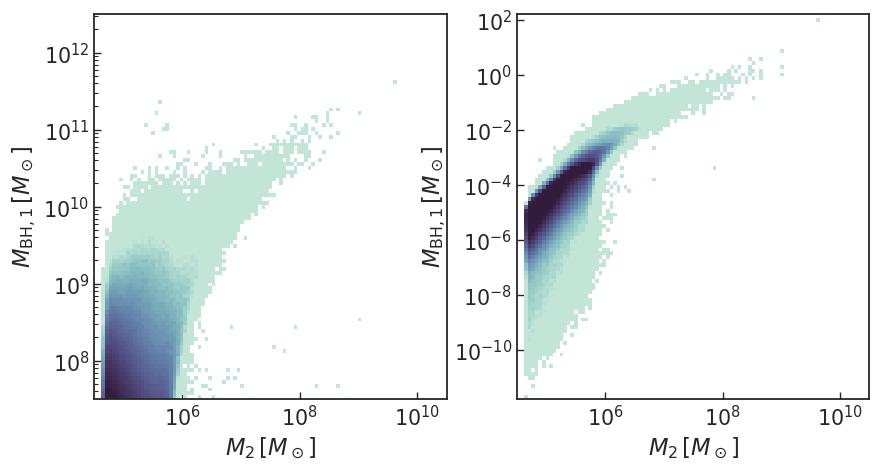

In [34]:
cc3 = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))


ymin, ymax = 7.5, 12.5
xmin, xmax = 4.5, 10.5

xbins = np.logspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)
ax[0].hist2d(bhmass5, gal_mass5, bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[0].set(xscale='log', yscale='log', xlabel=r'$M_{2}\,[M_\odot]$', ylabel=r'$M_{\rm BH, 1}\,[M_\odot]$')



ymin, ymax = np.log10(np.min(mdot)), np.log10(np.max(mdot))
xmin, xmax = 4.5, 10.5

xbins = np.logspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)
ax[1].hist2d(bhmass5, mdot, bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[1].set(xscale='log', yscale='log', xlabel=r'$M_{2}\,[M_\odot]$', ylabel=r'$M_{\rm BH, 1}\,[M_\odot]$')
